http://www.face-rec.org/algorithms/PCA/jcn.pdf
    
http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf

In [75]:
# Import library / packages

# For numerical operation
import numpy as np

# Pandas for tabular manipulations
import pandas as pd

# For plots
from matplotlib import pyplot as plt

# Support Vector Machine
from sklearn.svm import SVC

# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the data (saved in previous note book )
X_train = np.load("Result01\X_train.npy", )
X_test = np.load("Result01\X_test.npy")
Y_train = np.load("Result01\Y_train.npy")
Y_test = np.load("Result01\Y_test.npy")
Weight_train = np.load("Result01\Weight_train.npy")
Weight_test = np.load("Result01\Weight_test.npy")
Eigen_val = np.load("Result01\Eigen_val.npy")
Eigen_vec = np.load("Result01\Eigen_vec.npy")
Mean_face =np.load("Result01\Mean_face.npy")

In [148]:
# Train the model and plot the accuracy
def model_find_components(model, Xform_func, W_train, Y_train, W_test, Y_test, plot = 'Y') :
    Train_pred = np.array([]); Test_pred = np.array([])
    for i in range(W_train.shape[1]) :
        
        X_train = Xform_func(W_train,i)
        X_test = Xform_func(W_test,i)
        
        # Train the model
        model.fit(X_train,Y_train.ravel())
    
        # Predict the result
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)
        Train_pred = np.append(Train_pred,np.sum(Y_train_pred.reshape(-1) == Y_train.reshape(-1))*100/280)
        Test_pred = np.append(Test_pred,np.sum(Y_test_pred.reshape(-1) == Y_test.reshape(-1))*100/120)
        
    if plot == 'Y' :
        plt.figure(figsize=(20,8))
        plt.plot(Train_pred, label = 'Train', color = 'green')
        plt.plot(Test_pred, label = 'Test', color = 'red')
        plt.legend()
        plt.xlabel('Components', fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)
        plt.title('Accuracy of model prediction vs Number of components')
        plt.show()
    
    return(Train_pred, Test_pred)
    

In [149]:
Train_out = dict(); Test_out = dict()

In [150]:
# Find mean weights by class
Weight_meanbyclass = pd.concat([pd.DataFrame(Y_train, columns = ['Label']), pd.DataFrame(Weight_train)], axis = 1)\
                                .groupby(['Label']).mean().values


In [151]:
# Find std weights by class
Weight_stdbyclass = pd.concat([pd.DataFrame(Y_train, columns = ['Label']), pd.DataFrame(Weight_train)], axis = 1)\
                                .groupby(['Label']).std().values


In [152]:
# Define a custom kernel
def eu_kernel(X,Mean, comp = 1) :
    output = np.zeros([X.shape[0], Mean.shape[0]])    
    for i in range(X.shape[0]) :
        for j in range(Mean.shape[0]) :
            output[i,j] = np.square(np.linalg.norm(X[i,0:comp+1]-Mean[j,0:comp+1]))
    return(output)

In [153]:
# Define a custom kernel
def mh_kernel(X,Mean,std, comp = 1) :
    output = np.zeros([X.shape[0], Mean.shape[0]])        
    for i in range(X.shape[0]) :
        for j in range(Mean.shape[0]) :
            output[i,j] = np.square(np.linalg.norm((X[i,0:comp+1]-Mean[j,0:comp+1])/std[j,0:comp+1]))
    return(output)

In [154]:
# Support vector machine (RBF kernel)
model = SVC(kernel='rbf', gamma='auto')
Train_out['SVCRBF'], Test_out['SVCRBF'] = model_find_components(model, \
                                            lambda x, i: x[:,0:i+1], \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [155]:
# KNN model (Euclidean distance and 1 neighbour)
model = KNeighborsClassifier(n_neighbors=1)
Train_out['KNN1EU'], Test_out['KNN1EU'] = model_find_components(model,\
                                            lambda x, i: x[:,0:i+1], \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [156]:
# KNN model (Mahalanobis distance and 1 neighbour)
model = KNeighborsClassifier(n_neighbors=1)
W_train = Weight_train / np.sqrt(Eigen_val)
W_test = Weight_test / np.sqrt(Eigen_val)
Train_out['KNN1MH'], Test_out['KNN1MH'] = model_find_components(model,\
                                            lambda x, i: x[:,0:i+1], \
                                            W_train, Y_train, W_test, Y_test, plot = 'N')

In [157]:
# Support vector machine (linear kernel and euclidean distance from each class as features)
model = SVC(kernel='linear', gamma='auto')
Train_out['SVCLEU'], Test_out['SVCLEU'] = model_find_components(model, \
                                            lambda x, i: eu_kernel(x, Weight_meanbyclass,i), \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [158]:
# Support vector machine (linear kernel and mahalanobis distance from each class as features)
model = SVC(kernel='linear', gamma='auto')
Train_out['SVCLMH'], Test_out['SVCLMH'] = model_find_components(model, \
                                            lambda x, i: mh_kernel(x, Weight_meanbyclass,Weight_stdbyclass,i), \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [160]:
Method = dict()
Method['SVCRBF'] = 'SVC RBF (Weights)'
Method['SVCLEU'] = 'SVC Linear (EU distance)'
Method['SVCLMH'] = 'SVC Linear (MH distance)'
Method['KNN1EU'] = 'KNN 1 neigbour and EU distance (Weights)'
Method['KNN1MH'] = 'KNN 1 neigbour and MH distance (Weights)'

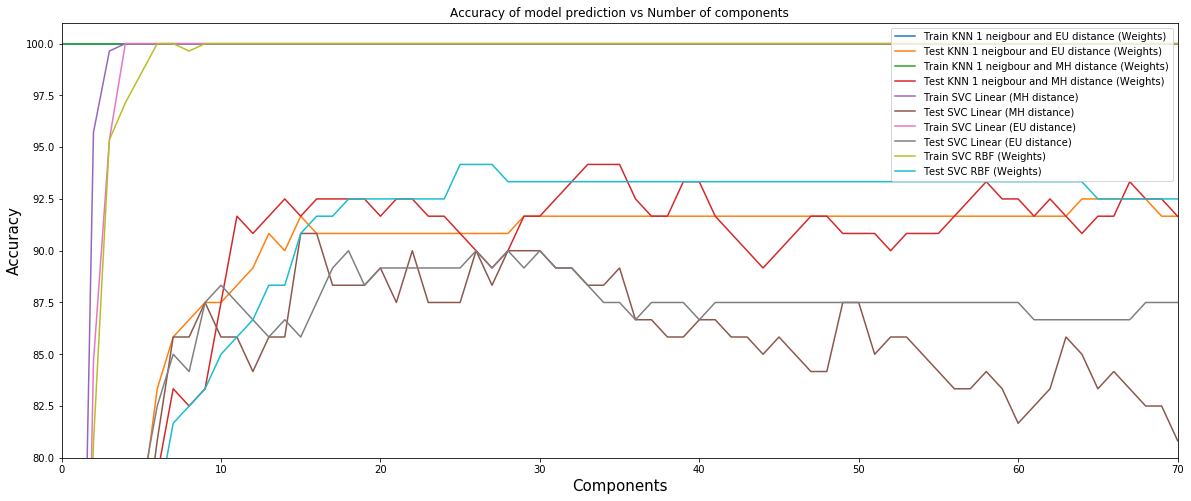

In [164]:
# Plot all output
plt.figure(figsize=(20,8))

for key in Train_out.keys():
    plt.plot(Train_out[key], label = 'Train ' + Method[key])
    plt.plot(Test_out[key], label = 'Test '+ Method[key])

plt.legend(loc = 'upper right')
plt.xlabel('Components', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy of model prediction vs Number of components')
plt.ylim(80,101)
plt.xlim(0,70)
plt.show()


In [216]:
# Final model
model = SVC(kernel='rbf', gamma='auto')

# Pick 30 components
W_train = Weight_train[:,0:31]
W_test = Weight_test[:,0:31]

# Train the model
model.fit(W_train,Y_train.ravel())
    
# Predict the result
Y_train_pred = model.predict(W_train)
Y_test_pred = model.predict(W_test)

print("Train Accuracy : {} and Test Accuracy {}"\
      .format((np.sum(Y_train_pred.reshape(-1) == Y_train.reshape(-1))*100/280), \
      np.sum(Y_test_pred.reshape(-1) == Y_test.reshape(-1))*100/120))



Train Accuracy : 100.0 and Test Accuracy 93.33333333333333


In [234]:

for i, _ in enumerate(Y_test_pred.reshape(-1)) :
    if Y_test_pred.reshape(-1)[i] != Y_test.reshape(-1)[i] :
        print("Test :",Weight_test[i,0:4])
        print("Mean pred", Y_test_pred[i], Weight_meanbyclass[Y_test_pred[i],0:4])
        print("Mean actual", Y_test[i], Weight_meanbyclass[Y_test[i],0:4])

Test : [-6.1947646  -0.03879391 -3.503219    1.9834602 ]
Mean pred 15 [-4.1901026  -0.8007446  -2.4663281   0.48075646]
Mean actual [0] [[-4.8314505  2.0865588  1.4075884  1.19042  ]]
Test : [-2.7097783   3.3549454   0.9082618  -0.42662668]
Mean pred 12 [-1.8188759   2.4495454   0.13983038 -0.20224875]
Mean actual [24] [[-0.13702501 -3.0924046   0.7717342   0.42279792]]
Test : [-4.4454618   4.2330575  -3.006842    0.82636803]
Mean pred 0 [-4.8314505  2.0865588  1.4075884  1.19042  ]
Mean actual [15] [[-4.1901026  -0.8007446  -2.4663281   0.48075646]]
Test : [-4.283185   6.8956842  1.7398254 -0.4797263]
Mean pred 34 [2.0885227  2.0797126  0.39415738 1.4125774 ]
Mean actual [9] [[-1.018122  -3.2471094  2.9663687  1.7559838]]
Test : [ 0.21804345  1.0197986   3.455009   -4.5598636 ]
Mean pred 2 [-0.11726736  0.86990815  2.4568794  -0.7209173 ]
Mean actual [25] [[ 1.1762908 -2.2241435  2.738964  -2.3301566]]
Test : [-1.2758046  -3.4587283  -0.01337387  1.8491597 ]
Mean pred 3 [-1.2031212  -

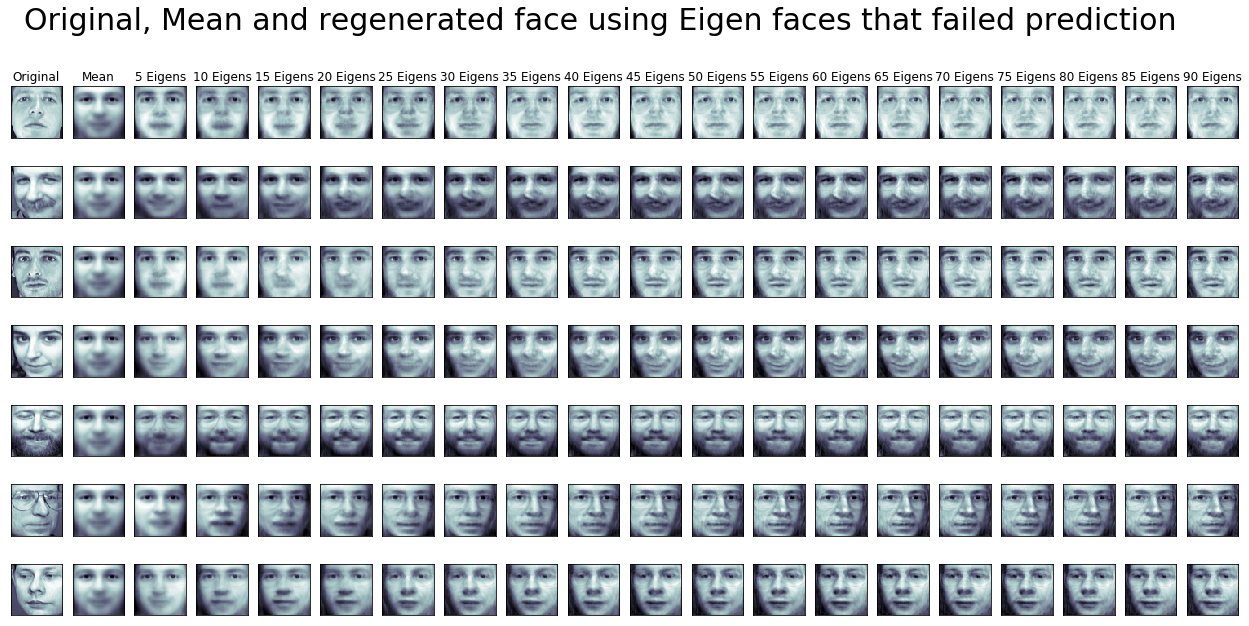

In [242]:
# Regenerate faces (that failed prediction)
fig, axes = plt.subplots(7,20,figsize=(22,10),\
                            subplot_kw = {'xticks':[],'yticks':[]})

plt.suptitle('Original, Mean and regenerated face using Eigen faces that failed prediction ', fontsize = 30)

failed_faces = list()
for i, _ in enumerate(Y_test_pred.reshape(-1)) :
    if Y_test_pred.reshape(-1)[i] != Y_test.reshape(-1)[i] :
        failed_faces.append(i)

for i, ax in enumerate(axes.flat) :
    j = failed_faces[int(i / 20)]
    if (i % 20 ) == 0 :
        ax.imshow(X_test[j,:].reshape(64,64), cmap = 'bone')
        if int(i / 20) == 19 :
            ax.set_xlabel('Original')
        elif int(i / 20) == 0 :
            ax.set_title('Original')
    elif (i % 20 ) == 1 :
        ax.imshow(Mean_face.reshape(64,64), cmap = 'bone')
        if int(i / 20) == 19 :
            ax.set_xlabel('Mean')
        elif int(i / 20) == 0 :
            ax.set_title('Mean')
    elif (i % 20 ) > 1 :
        k = 5*((i % 20)-1)
        face = Mean_face.reshape(1,-1) + np.dot(Weight_test[j,0:k],Eigen_vec[0:k,:])
        ax.imshow(face.reshape(64,64), cmap = 'bone')
        if int(i / 20) == 19 :
            ax.set_xlabel(str(k)+' Eigens')
        elif int(i / 20) == 0 : 
            ax.set_title(str(k)+' Eigens')
        
    